In [1]:
!pip install imbalanced-learn
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 4.6 MB/s eta 0:00:00


# Trabajo 2 redes


In [110]:
import os
import numpy as np
import pandas as pd
import kagglehub
import difflib
import seaborn as sns

# Scikit-learn para preprocesamiento y modelado clásico
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer  # Necesario para IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight

# Balanceo
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback


In [111]:
# -----------------------------------------------------------------------------
# 1. CARGA DE DATOS
# -----------------------------------------------------------------------------

# Download latest version
path = kagglehub.dataset_download("ranadeep/credit-risk-dataset")

print("Path to dataset files:", path)

datos_crudos = pd.read_csv(os.path.join(path,'loan/loan.csv'))

datos_crudos.head(2)

Path to dataset files: /root/.cache/kagglehub/datasets/ranadeep/credit-risk-dataset/versions/3


<ipython-input-111-e4968338497e>:10: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  datos_crudos = pd.read_csv(os.path.join(path,'loan/loan.csv'))


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
drop_columns = [ "addr_state",
    "annual_inc_joint",
    "application_type",
    "collection_recovery_fee",
    "desc",
    "dti_joint",
    "earliest_cr_line",
    "emp_title",
    "grade",
    "id",
    "issue_d",
    "last_credit_pull_d",
    "last_pymnt_d",
    "member_id",
    "mths_since_last_delinq",
    "mths_since_last_major_derog",
    "mths_since_last_record",
    "next_pymnt_d",
    "out_prncp",
    "out_prncp_inv",
    "policy_code",
    "purpose",
    "pymnt_plan",
    "recoveries",
    "title",
    "url",
    "verification_status_joint",
    "zip_code",
    "open_acc_6m",
    "open_il_6m",
    "open_il_12m",
    "open_il_24m",
    "mths_since_rcnt_il",
    "total_bal_il",
    "il_util",
    "open_rv_12m",
    "open_rv_24m",
    "max_bal_bc",
    "all_util",
    "inq_fi",
    "total_cu_tl",
    "inq_last_12m",
    'last_pymnt_amnt',
    'total_rec_prncp',
    'total_pymnt_inv',
    'total_rec_int' ]


datos_crudos.drop(drop_columns, axis = 1, inplace = True)

In [113]:
datos_crudos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   887379 non-null  float64
 1   funded_amnt                 887379 non-null  float64
 2   funded_amnt_inv             887379 non-null  float64
 3   term                        887379 non-null  object 
 4   int_rate                    887379 non-null  float64
 5   installment                 887379 non-null  float64
 6   sub_grade                   887379 non-null  object 
 7   emp_length                  842554 non-null  object 
 8   home_ownership              887379 non-null  object 
 9   annual_inc                  887375 non-null  float64
 10  verification_status         887379 non-null  object 
 11  loan_status                 887379 non-null  object 
 12  dti                         887379 non-null  float64
 13  delinq_2yrs   

In [114]:
datos_crudos.dropna(thresh = datos_crudos.shape[0]*0.6, axis = 1, inplace = True)

In [115]:
porcentaje_nulos = datos_crudos.isnull().mean() * 100
print(porcentaje_nulos)


loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
sub_grade                     0.000000
emp_length                    5.051393
home_ownership                0.000000
annual_inc                    0.000451
verification_status           0.000000
loan_status                   0.000000
dti                           0.000000
delinq_2yrs                   0.003268
inq_last_6mths                0.003268
open_acc                      0.003268
pub_rec                       0.003268
revol_bal                     0.000000
revol_util                    0.056571
total_acc                     0.003268
initial_list_status           0.000000
total_pymnt                   0.000000
total_rec_late_fee            0.000000
collections_12_mths_ex_med    0.016340
acc_now_delinq                0.003268
tot_coll_amt             

In [116]:
# -----------------------------------------------------------------------------
# 3. SEPARAR X, y Y AGRUPAR 'loan_status'
# -----------------------------------------------------------------------------
X_full = datos_crudos.drop("loan_status", axis=1)
y_full = datos_crudos["loan_status"].copy()

mapeo_loan_status = {
    "Current": "Current",
    "Fully Paid": "Fully Paid",
    "Charged Off": "Charged Off",
    "Late (31-120 days)": "Late",
    "Issued": "In Progress",
    "In Grace Period": "Late",
    "Late (16-30 days)": "Late",
    "Does not meet the credit policy. Status:Fully Paid": "Fully Paid",
    "Default": "Charged Off",
    "Does not meet the credit policy. Status:Charged Off": "Charged Off",
}
y_full = y_full.replace(mapeo_loan_status)

# -----------------------------------------------------------------------------
# 4. DIVIDIR TRAIN/VAL/TEST
# -----------------------------------------------------------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)
# Aprox 60% train, 20% val, 20% test


In [117]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class DateDiffTransformer(BaseEstimator, TransformerMixin):
    """
    Convierte columnas de fecha a número de meses desde
    la fecha de referencia.
    """
    def __init__(self, reference_date="2020-01-01"):
        self.reference_date = pd.to_datetime(reference_date)
        self._input_features = None

    def fit(self, X, y=None):
        # Guardar nombres de columnas de entrada
        if hasattr(X, "columns"):
            self._input_features = X.columns.to_list()
        else:
            # Si X no es DataFrame, definimos un genérico
            self._input_features = [f"col_{i}" for i in range(X.shape[1])]
        return self

    def transform(self, X):
        X_ = X.copy() if hasattr(X, "copy") else np.array(X)
        # Convertir cada columna a datetime, calcular meses
        if hasattr(X_, "columns"):
            for col in X_.columns:
                X_[col] = pd.to_datetime(X_[col], errors="coerce")
                X_[col] = (X_[col] - self.reference_date).dt.days / 30.4375
        else:
            # Caso: X_ sea un array numpy (más raro)
            # Necesitarías una lógica distinta, o forzar a dataframe antes
            pass
        return X_

    def get_feature_names_out(self, input_features=None):
        """
        Devuelve la lista de columnas resultantes.
        """
        if input_features is not None:
            return input_features
        # Si no se pasa input_features, usamos las que guardamos en fit()
        return self._input_features


In [118]:
cat_cols_temp

['term',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'initial_list_status']

In [119]:
# 8.1 Re-identificar numéricas/categóricas en "X_train_reduced"
num_cols_temp = X_train_full.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols_temp = X_train_full.select_dtypes(include=["object"]).columns.tolist()


for col in cat_cols_temp :
    # Aplica el strip a cada uno de train/val/test si existen en dichas columnas
    if col in X_train_full.columns:
        X_train_full[col] = X_train_full[col].str.strip()
    if col in X_val.columns:
        X_val[col] = X_val[col].str.strip()
    if col in X_test.columns:
        X_test[col] = X_test[col].str.strip()



# Decide cuáles son ordinales y cuáles son one-hot (si aplica)
# Ajusta tus listas ord_cat_cols, ohe_cat_cols según sea necesario
ord_cat_cols = ['emp_length', 'sub_grade', 'term']  # ejemplo
ohe_cat_cols = ['home_ownership', 'verification_status', 'initial_list_status']      # ejemplo

# Filtramos sólo las que realmente están en cat_cols
ord_cat_cols = [c for c in ord_cat_cols if c in cat_cols_temp]
ohe_cat_cols = [c for c in ohe_cat_cols if c in cat_cols_temp]

# Definir categorías para ordinal
ord_categories = [
   ["< 1 year",
     "1 year",
     "2 years",
     "3 years",
     "4 years",
     "5 years",
     "6 years",
     "7 years",
     "8 years",
     "9 years",
     "10+ years",
     "Missing"],  # 'emp_length'
    ['A1', 'A2', 'A3', 'A4', 'A5',
    'B1', 'B2', 'B3', 'B4', 'B5',
    'C1', 'C2', 'C3', 'C4', 'C5',
    'D1', 'D2', 'D3', 'D4', 'D5',
    'E1', 'E2', 'E3', 'E4', 'E5',
    'F1', 'F2', 'F3', 'F4', 'F5',
    'G1', 'G2', 'G3', 'G4', 'G5'],  # 'sub_grade'
    ["36 months", "60 months"]  # 'term'
]

# Pipeline para numéricos
from sklearn.impute import IterativeImputer
numeric_pipeline = Pipeline(steps=[
    ("imputer", IterativeImputer(random_state=42)),
])

# Pipeline para ordinales
from sklearn.impute import SimpleImputer
ordinal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ord_enc", OrdinalEncoder(categories=ord_categories))
])

# Pipeline para one-hot
ohe_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(drop="first", sparse_output=False))
])

# Pipeline para Fechas
date_pipeline = Pipeline([
    ("date2num", DateDiffTransformer(reference_date="2020-01-01")),
    # Después de convertir a numérico, posiblemente imputas valores NaN
    ("imputer", SimpleImputer(strategy="mean"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols_temp),
    ("ord", ordinal_pipeline, ord_cat_cols),
    ("ohe", ohe_pipeline, ohe_cat_cols),
  #  ("dates", date_pipeline, dt_cols),
], remainder="drop")

full_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("scaler", StandardScaler())
])


In [120]:
# -----------------------------------------------------------------------------
# 5. PRESELECCIÓN (RÁPIDA) DE VARIABLES CON UN RF "EXPLORATORIO"
# -----------------------------------------------------------------------------
# En este caso, para no complicarnos con OneHot/Ordinal, podemos hacer:
# - Imputación simple en numéricas con "median"
# - Imputación simple en categóricas con "Missing"
# - Convertir todas categóricas con pd.get_dummies (drop_first=True) o algo similar
#   de forma "rápida"
# Luego entrenar un RF para ver importancia de columna

X_train_prepared = full_pipeline.fit_transform(X_train_full, y_train_full)

In [121]:
feature_names = full_pipeline.named_steps["preprocess"].get_feature_names_out()

# 2) Sincronizas con la salida final, recordando que StandardScaler no cambia la cantidad de columnas
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=feature_names)

# 3) Entrenas el RF con X_train_prepared_df, que ya tiene nombres
rf_explor = RandomForestClassifier(n_estimators=100, random_state=42)
rf_explor.fit(X_train_prepared_df, y_train_full)

importances = rf_explor.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

In [124]:
len(list(feature_names))

32

In [128]:
topN = 13
top_features = feat_imp_df["feature"].iloc[:topN].values
top_features = [col.split('__')[-1] for col in top_features]

print("Top features (después del RF exploratorio):")
print(top_features)
len(top_features)

Top features (después del RF exploratorio):
['total_pymnt', 'installment', 'funded_amnt_inv', 'funded_amnt', 'int_rate', 'loan_amnt', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'dti', 'revol_bal', 'revol_util', 'sub_grade']


13

In [129]:

# -----------------------------------------------------------------------------
# 6. MAPEAR esas top_features a las columnas originales
# -----------------------------------------------------------------------------
# Cuando se genera un dummy "home_ownership_RENT", proviene de la col "home_ownership".
# Sin embargo, esto nos indica que la columna original "home_ownership" sí parece relevante.
#
# Paso sencillo: extrayendo el prefijo antes del guión bajo,
#   p.e. "home_ownership_RENT" => "home_ownership"
#   pero esto no siempre es exacto si tienes nombres con "_" dentro.
#
# Lo que podemos hacer en la práctica: chequear manualmente
# con un diccionario. Pero en este ejemplo, solo sacamos lo que
# hay antes del primer "_".

def match_feature_to_col(feature, final_cols, threshold=0.7):
    """
    Busca en 'final_cols' la columna que mejor se asemeje a 'feature' usando
    difflib.SequenceMatcher. Solo se retorna el match si la similitud es mayor
    o igual a 'threshold'.
    """
    # 1) Si hay coincidencia exacta, la retornamos
    if feature in final_cols:
        return feature

    # 2) Si 'feature' contiene guiones bajos, extraemos la subcadena antes del primer "_"
    candidate = feature.split("_")[0] if "_" in feature else feature

    best_match = None
    best_ratio = 0.0

    # 3) Recorremos las columnas disponibles para encontrar la de mayor similitud
    for col in final_cols:
        ratio = difflib.SequenceMatcher(None, candidate, col).ratio()
        if ratio > best_ratio:
            best_ratio = ratio
            best_match = col

    # 4) Retornamos el mejor match solo si la similitud es suficientemente alta
    if best_ratio >= threshold:
        return best_match
    else:
        return None


# Ejemplo de aplicación:
used_cols = set()
feature_to_original = {}

features_df = list(datos_crudos.columns)  # Asegúrate de que 'datos_crudos' es tu dataframe original

for feat in top_features:
    # Excluimos de la búsqueda las columnas ya usadas para evitar repeticiones
    available_cols = [col for col in features_df if col not in used_cols]

    matched_col = match_feature_to_col(feat, available_cols, threshold=0.5)

    if matched_col is not None:
        feature_to_original[feat] = matched_col
        used_cols.add(matched_col)
    else:
        feature_to_original[feat] = None

print("Mapeo resultante (feature -> columna mapeada):")
for f, c in feature_to_original.items():
    print(f"{f} -> {c}")

# Obtenemos el vector relevante, filtrando los None
relevant_original_cols = [col for col in feature_to_original.values() if col is not None]
print("\nVector relevant_a_original_cols:")
print(relevant_original_cols)


Mapeo resultante (feature -> columna mapeada):
total_pymnt -> total_pymnt
installment -> installment
funded_amnt_inv -> funded_amnt_inv
funded_amnt -> funded_amnt
int_rate -> int_rate
loan_amnt -> loan_amnt
tot_coll_amt -> tot_coll_amt
tot_cur_bal -> tot_cur_bal
total_rev_hi_lim -> total_rev_hi_lim
dti -> dti
revol_bal -> revol_bal
revol_util -> revol_util
sub_grade -> sub_grade

Vector relevant_a_original_cols:
['total_pymnt', 'installment', 'funded_amnt_inv', 'funded_amnt', 'int_rate', 'loan_amnt', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'dti', 'revol_bal', 'revol_util', 'sub_grade']


In [130]:
# -----------------------------------------------------------------------------
# 7. Filtrar el DataFrame "crudo" para quedarnos sólo con esas columnas
# -----------------------------------------------------------------------------
# Ojo: si una columna venía de la dummy 'home_ownership_RENT',
# la original es 'home_ownership', así que no necesitas quedarte con
# "home_ownership_RENT" (esa no existe en crudo).
#
# Por ejemplo, si "loan_amnt" está en relevant_original_cols,
# ya existe en el DataFrame.
#
# Si "home_ownership" está en relevant_original_cols,
# la conservamos para codificarla con OneHot en el pipeline final.

X_train_reduced = X_train_full[relevant_original_cols].copy()
X_val_reduced   = X_val[relevant_original_cols].copy()
X_test_reduced  = X_test[relevant_original_cols].copy()

# -----------------------------------------------------------------------------
# 8. Ahora definimos el pipeline DEFINITIVO (solo con las col originales elegidas)
# -----------------------------------------------------------------------------
# 8.1 Re-identificar numéricas/categóricas en "X_train_reduced"
num_cols = X_train_reduced.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_train_reduced.select_dtypes(include=["object"]).columns.tolist()

# Decide cuáles son ordinales y cuáles son one-hot (si aplica)
# Ajusta tus listas ord_cat_cols, ohe_cat_cols según sea necesario
for col in cat_cols :
    # Aplica el strip a cada uno de train/val/test si existen en dichas columnas
    if col in X_train_full.columns:
        X_train_reduced[col] = X_train_reduced[col].str.strip()
    if col in X_val.columns:
        X_val_reduced [col] = X_val_reduced [col].str.strip()
    if col in X_test.columns:
        X_test_reduced[col] = X_test_reduced [col].str.strip()



# Decide cuáles son ordinales y cuáles son one-hot (si aplica)
# Ajusta tus listas ord_cat_cols, ohe_cat_cols según sea necesario
ord_cat_cols = ['sub_grade']  # ejemplo
ohe_cat_cols = ['initial_list_status']      # ejemplo
# dt_cols = ['earliest_cr_line',  'issue_d']

# Filtramos sólo las que realmente están en cat_cols
ord_cat_cols = [c for c in ord_cat_cols if c in cat_cols]
ohe_cat_cols = [c for c in ohe_cat_cols if c in cat_cols]
dt_cols = [c for c in dt_cols if c in cat_cols_temp]

# Definir categorías para ordinal
ord_categories = [
  # 'emp_length'
    ['A1', 'A2', 'A3', 'A4', 'A5',
    'B1', 'B2', 'B3', 'B4', 'B5',
    'C1', 'C2', 'C3', 'C4', 'C5',
    'D1', 'D2', 'D3', 'D4', 'D5',
    'E1', 'E2', 'E3', 'E4', 'E5',
    'F1', 'F2', 'F3', 'F4', 'F5',
    'G1', 'G2', 'G3', 'G4', 'G5'],  # 'sub_grade'

]

# Pipeline para numéricos
from sklearn.impute import IterativeImputer
numeric_pipeline = Pipeline(steps=[
    ("imputer", IterativeImputer(random_state=42)),
])

# Pipeline para ordinales
from sklearn.impute import SimpleImputer
ordinal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ord_enc", OrdinalEncoder(categories=ord_categories))
])

# Pipeline para one-hot
ohe_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(drop="first", sparse_output=False))
])

# Pipeline para Fechas
date_pipeline = Pipeline([
    ("date2num", DateDiffTransformer(reference_date="2020-01-01")),
    # Después de convertir a numérico, posiblemente imputas valores NaN
    ("imputer", SimpleImputer(strategy="mean"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("ord", ordinal_pipeline, ord_cat_cols),
    ("ohe", ohe_pipeline, ohe_cat_cols),
  #  ("dates", date_pipeline, dt_cols),
], remainder="drop")

full_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("scaler", StandardScaler())
])



In [131]:
# -----------------------------------------------------------------------------
# 9. AJUSTAR ESTE PIPELINE CON X_train_reduced, y luego transformar val y test
# -----------------------------------------------------------------------------
X_train_final = full_pipeline.fit_transform(X_train_reduced, y_train_full)
X_val_final   = full_pipeline.transform(X_val_reduced)
X_test_final  = full_pipeline.transform(X_test_reduced)

In [132]:
# -----------------------------------------------------------------------------
# 11. BALANCEO DE CLASES (UNDERSAMPLING + SMOTE) EN EL TRAIN
# -----------------------------------------------------------------------------

# Revisar la distribución de y_train
print("Distribución (train) antes de re-muestreo:")
print(y_train_full.value_counts())

undersample_strategy = {
    "Current": 100000,  # ejemplo, reducir la clase mayoritaria
    "Fully Paid": 80000,
}
oversample_strategy = {
    "Charged Off": 50000,
    "Late": 30000,
    "In Progress": 70000,
}

balance_pipeline = ImbPipeline([
    ("under", RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)),
    ("smote", SMOTE(sampling_strategy=oversample_strategy, random_state=42))
])

# Importante: re-muestrear X_train_prepared_reduced (la matriz numérica) y y_train
X_train_bal, y_train_bal = balance_pipeline.fit_resample(X_train_final, y_train_full)

print("Distribución (train) DESPUÉS de re-muestreo:")
print(pd.Series(y_train_bal).value_counts())


Distribución (train) antes de re-muestreo:
loan_status
Current        361097
Fully Paid     125911
Charged Off     28297
Late            12060
In Progress      5062
Name: count, dtype: int64
Distribución (train) DESPUÉS de re-muestreo:
loan_status
Current        100000
Fully Paid      80000
In Progress     70000
Charged Off     50000
Late            30000
Name: count, dtype: int64


In [133]:
# -----------------------------------------------------------------------------
# 12. PREPARAR LAS ETIQUETAS PARA ENTRENAMIENTO (One-Hot)
# -----------------------------------------------------------------------------
# Convertimos las categorías a índices (0,1,2,...) con LabelEncoder, luego OneHot

label_encoder = LabelEncoder()
y_train_bal_enc = label_encoder.fit_transform(y_train_bal)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

# OneHot
from sklearn.preprocessing import OneHotEncoder
onehot_enc = OneHotEncoder(sparse_output=False)

y_train_bal_onehot = onehot_enc.fit_transform(y_train_bal_enc.reshape(-1, 1))
y_val_onehot = onehot_enc.transform(y_val_enc.reshape(-1, 1))
y_test_onehot = onehot_enc.transform(y_test_enc.reshape(-1, 1))

n_clases = y_train_bal_onehot.shape[1]
print("Número de clases totales (agrupadas):", n_clases)
print("Clases en LabelEncoder:", label_encoder.classes_)

Número de clases totales (agrupadas): 5
Clases en LabelEncoder: ['Charged Off' 'Current' 'Fully Paid' 'In Progress' 'Late']


In [134]:
# -----------------------------------------------------------------------------
# 13. DEFINIR ARQUITECTURA DE LA RED NEURONAL
# -----------------------------------------------------------------------------

# Ejemplo de una red con menos capas que el ejemplo original (para datos tabulares)
def build_model(input_dim, n_classes):
    model = Sequential()
    model.add(Dense(256, activation="relu", input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(128, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(n_classes, activation="softmax"))
    return model

model = build_model(input_dim=X_train_bal.shape[1], n_classes=n_clases)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [135]:
# -----------------------------------------------------------------------------
# 14. FOCAL LOSS (OPCIONAL) O CROSSENTROPY
# -----------------------------------------------------------------------------
def focal_loss_multiclass(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal = alpha * tf.pow((1 - y_pred), gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))
    return loss
# -----------------------------------------------------------------------------
# 15. CALLBACK PERSONALIZADO PARA MOSTRAR METRICS POR CLASE TRAS CADA EPOCH
# -----------------------------------------------------------------------------
class ExtendedMetricsCallback(Callback):
    def __init__(self, val_data, val_labels, label_encoder):
        super().__init__()
        self.val_data = val_data
        self.val_labels = val_labels
        self.label_encoder = label_encoder

    def on_epoch_end(self, epoch, logs=None):
        val_preds = self.model.predict(self.val_data)
        val_pred_labels = np.argmax(val_preds, axis=1)
        val_true_labels = np.argmax(self.val_labels, axis=1)

        # Reporte
        print("==== Classification Report (Val) epoch {} ====".format(epoch + 1))
        print(
            classification_report(
                val_true_labels,
                val_pred_labels,
                target_names=self.label_encoder.classes_
            )
        )

In [136]:
# -----------------------------------------------------------------------------
# 16. COMPILAR Y ENTRENAR
# -----------------------------------------------------------------------------

# Ejemplo: Focal loss con Adam y LR 0.001
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss_multiclass(alpha=0.25, gamma=2.0),
    metrics=["accuracy"]
)

# Callbacks: EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
extended_metrics_cb = ExtendedMetricsCallback(
    val_data=X_val_final,
    val_labels=y_val_onehot,
    label_encoder=label_encoder
)

history = model.fit(
    X_train_bal,
    y_train_bal_onehot,
    validation_data=(X_val_final, y_val_onehot),
    epochs=10,
    batch_size=256,
    callbacks=[early_stopping, lr_scheduler, extended_metrics_cb]
)


Epoch 1/10
5547/5547 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
==== Classification Report (Val) epoch 1 ====
              precision    recall  f1-score   support

 Charged Off       0.40      0.60      0.48      9509
     Current       0.95      0.85      0.90    120560
  Fully Paid       0.87      0.99      0.92     41689
 In Progress       0.39      0.99      0.56      1695
        Late       0.08      0.05      0.06      4023

    accuracy                           0.86    177476
   macro avg       0.54      0.70      0.58    177476
weighted avg       0.87      0.86      0.86    177476

1290/1290 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.6367 - loss: 0.1317 - val_accuracy: 0.8552 - val_loss: 0.0567 - learning_rate: 0.0010
Epoch 2/10
5547/5547 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
==== Classification Report (Val) epoch 2 ====
              precision    recall  f1-score   support

 Charged Off       0.55      0.58      0.56      9509
     Current       0.94      0.89      0.92    120560
  F

In [140]:
# -----------------------------------------------------------------------------
# 17. EVALUAR EN TEST
# -----------------------------------------------------------------------------
X_test_final  = full_pipeline.transform(X_test_reduced)

test_preds = model.predict(X_test_final)
test_pred_labels = np.argmax(test_preds, axis=1)
test_true_labels = np.argmax(y_test_onehot, axis=1)

print("==== REPORT EN TEST ====")
print(
    classification_report(
        test_true_labels,
        test_pred_labels,
        target_names=label_encoder.classes_
    )
)

5547/5547 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
==== REPORT EN TEST ====
              precision    recall  f1-score   support

 Charged Off       0.68      0.73      0.70      9422
     Current       0.96      0.90      0.93    120122
  Fully Paid       0.89      1.00      0.94     42111
 In Progress       0.36      1.00      0.53      1703
        Late       0.13      0.09      0.11      4118

    accuracy                           0.89    177476
   macro avg       0.60      0.74      0.64    177476
weighted avg       0.90      0.89      0.89    177476



5547/5547 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


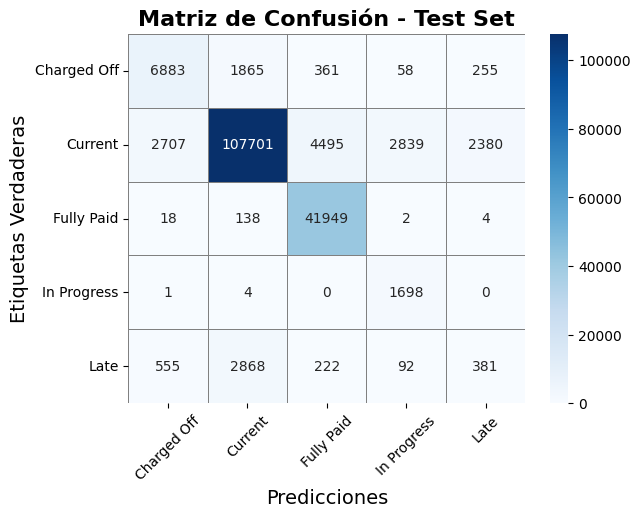

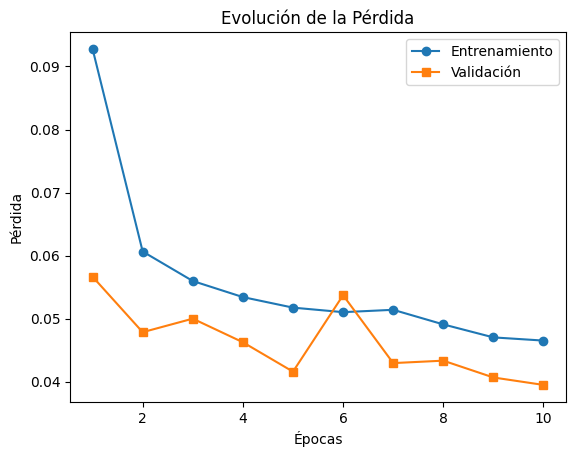

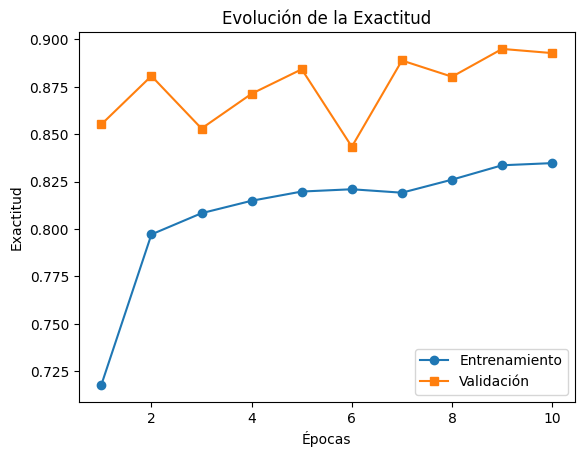

In [141]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# -------------------------------------------------------------------------
# 19. MATRIZ DE CONFUSIÓN
# -------------------------------------------------------------------------
def plot_confusion_matrix(X_test_prepared, y_test_onehot, model, label_encoder):
    """
    Genera la matriz de confusión del conjunto de prueba y la grafica con matplotlib.
    """
    # Obtener predicciones
    y_test_pred_onehot = model.predict(X_test_prepared)
    y_test_pred = np.argmax(y_test_pred_onehot, axis=1)    # Índices predichos
    y_test_true = np.argmax(y_test_onehot, axis=1)         # Índices reales

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test_true, y_test_pred)

    # Etiquetas de clase (mapeadas desde el LabelEncoder)
    class_labels = label_encoder.classes_

    # Crear la figura de la matriz de confusión
    plt.figure()

    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, linewidths=0.5, linecolor='gray')
    plt.title("Matriz de Confusión - Test Set", fontsize=16, fontweight='bold')
    plt.xlabel("Predicciones", fontsize=14)
    plt.ylabel("Etiquetas Verdaderas", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# -------------------------------------------------------------------------
# 20. GRÁFICO DE PÉRDIDA (LOSS)
# -------------------------------------------------------------------------
def plot_loss(history):
    """
    Grafica la pérdida de entrenamiento y validación en figuras separadas.
    """
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure()
    plt.plot(epochs, history.history['loss'], label='Entrenamiento', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validación', marker='s')
    plt.title("Evolución de la Pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.show()


# -------------------------------------------------------------------------
# 21. GRÁFICO DE EXACTITUD (ACCURACY)
# -------------------------------------------------------------------------
def plot_accuracy(history):
    """
    Grafica la exactitud (accuracy) de entrenamiento y validación.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure()
    plt.plot(epochs, history.history['accuracy'], label='Entrenamiento', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validación', marker='s')
    plt.title("Evolución de la Exactitud")
    plt.xlabel("Épocas")
    plt.ylabel("Exactitud")
    plt.legend()
    plt.show()


# -------------------------------------------------------------------------
# EJEMPLO DE USO TRAS ENTRENAR EL MODELO:
# -------------------------------------------------------------------------
# Suponiendo que ya tienes:
#   - X_test_prepared_reduced (o como llames a tu X_test procesado)
#   - y_test_onehot (etiquetas one-hot del test)
#   - model (tu red neuronal entrenada)
#   - label_encoder (para mapear índices -> nombres de clases)
#   - history (el History devuelto por model.fit)

plot_confusion_matrix(X_test_final, y_test_onehot, model, label_encoder)
plot_loss(history)
plot_accuracy(history)


In [144]:
label_encoder.classes_

array(['Charged Off', 'Current', 'Fully Paid', 'In Progress', 'Late'],
      dtype=object)

In [142]:
model.save('modelo_correccion1.h5')

In [145]:
import joblib

# Guardar el pipeline entrenado en disco
joblib.dump(full_pipeline, 'full_pipeline.pkl')


['full_pipeline.pkl']

In [146]:
X_test_reduced

,total_pymnt,installment,funded_amnt_inv,funded_amnt,int_rate,loan_amnt,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,dti,revol_bal,revol_util,sub_grade
550946,8079.79,279.72,8000.0,8000.0,15.61,8000.0,0.0,66233.0,6650.0,25.71,3324.0,50.0,D1
292628,10186.50,679.10,21000.0,21000.0,10.15,21000.0,0.0,81146.0,14900.0,22.33,11443.0,76.8,B2
739899,20360.22,617.11,19725.0,19725.0,7.89,19725.0,0.0,309243.0,16200.0,14.12,12272.0,75.8,A5
302859,4227.73,279.72,8000.0,8000.0,15.61,8000.0,0.0,38526.0,15500.0,32.07,8285.0,53.5,D1
653323,6205.36,1247.68,34875.0,35000.0,16.99,35000.0,0.0,88745.0,53600.0,25.19,37851.0,70.6,D3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243312,6648.11,513.77,20000.0,20000.0,18.54,20000.0,687.0,31104.0,32300.0,11.06,14188.0,43.9,E1
648185,3126.88,786.93,22075.0,22075.0,16.99,22075.0,0.0,12518.0,24900.0,9.40,12518.0,50.3,D3
570650,292.80,98.21,3000.0,3000.0,10.99,3000.0,2054.0,20755.0,11800.0,33.23,4222.0,35.8,B4
877602,5214.57,160.27,5100.0,5100.0,8.19,5100.0,1515.0,157411.0,23700.0,20.83,5876.0,24.8,A5
